In [126]:
file_to_check = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data/hrrr_uv_agl_2024_08.nc" # Or any other file

# --- 3. Extract coordinates and compare ---
with xr.open_dataset(file_to_check) as ds:
    print((ds['u'].sel(height_m=40) != ds['u'].sel(height_m=140)).any().compute())
    print((ds['v'].sel(height_m=40) != ds['v'].sel(height_m=140)).any().compute())

<xarray.DataArray 'u' ()>
array(False)
Coordinates:
    latitude   float64 41.17
    longitude  float64 -71.58
<xarray.DataArray 'v' ()>
array(False)
Coordinates:
    latitude   float64 41.17
    longitude  float64 -71.58


In [128]:
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

print("--- Cell 1: Setup Complete ---")
print("Libraries imported.")

# --- File Paths and Parameters ---
# Path to your HRRR data directory
HRRR_DIR = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/HRRR_Data"

# List of the HRRR files for the C1A period
HRRR_FILES = [
    "hrrr_uv_agl_2022_08.nc", "hrrr_uv_agl_2022_09.nc", "hrrr_uv_agl_2022_10.nc",
    "hrrr_uv_agl_2022_11.nc", "hrrr_uv_agl_2022_12.nc", "hrrr_uv_agl_2023_01.nc",
    "hrrr_uv_agl_2023_02.nc", "hrrr_uv_agl_2023_03.nc", "hrrr_uv_agl_2023_04.nc",
    "hrrr_uv_agl_2023_05.nc", "hrrr_uv_agl_2023_06.nc", "hrrr_uv_agl_2023_07.nc",
    "hrrr_uv_agl_2023_08.nc", "hrrr_uv_agl_2023_09.nc", "hrrr_uv_agl_2023_10.nc",
    "hrrr_uv_agl_2023_11.nc",

    "hrrr_uv_agl_2023_12.nc", "hrrr_uv_agl_2024_01.nc", "hrrr_uv_agl_2024_02.nc", 
    "hrrr_uv_agl_2024_02.nc", "hrrr_uv_agl_2024_03.nc", "hrrr_uv_agl_2024_04.nc", 
    "hrrr_uv_agl_2024_05.nc", "hrrr_uv_agl_2024_06.nc", "hrrr_uv_agl_2024_07.nc", 
    "hrrr_uv_agl_2024_08.nc", "hrrr_uv_agl_2024_09.nc", "hrrr_uv_agl_2024_10.nc", 
    "hrrr_uv_agl_2024_11.nc", "hrrr_uv_agl_2024_12.nc", "hrrr_uv_agl_2025_01.nc", 
    "hrrr_uv_agl_2025_02.nc", "hrrr_uv_agl_2025_03.nc", "hrrr_uv_agl_2025_04.nc", 
    "hrrr_uv_agl_2025_05.nc", "hrrr_uv_agl_2025_06.nc"
]

# Path to your processed Lidar data
LIDAR_FILE_PATH = "/Users/mirabel.luo/Documents/AWAKEN/AWAKEN-A1-A2_LiDAR/SiteC1A"

# --- Analysis Period and Heights ---
C1A_START_DATE = "2022-08-28"
C1A_END_DATE = "2023-11-06"

# Combine directory and file names
hrrr_filepaths = [os.path.join(HRRR_DIR, f) for f in HRRR_FILES]

print(f"Configuration loaded for C1A period: {C1A_START_DATE} to {C1A_END_DATE}")


--- Cell 1: Setup Complete ---
Libraries imported.
Configuration loaded for C1A period: 2022-08-28 to 2023-11-06


In [89]:
print("\n--- Cell 2: Loading Processed Lidar Data ---")

try:
    # Load the pre-processed Lidar data from your other notebook
    df_lidar_analysis = pd.read_csv(LIDAR_PROCESSED_FILE)
    
    # Ensure the 'time' column is in datetime format
    df_lidar_analysis['time'] = pd.to_datetime(df_lidar_analysis['time'])    
    
    print("Successfully loaded and standardized processed Lidar data.")
    print(df_lidar_analysis.head())

except FileNotFoundError:
    print(f"Error: Processed Lidar file not found at '{LIDAR_PROCESSED_FILE}'")
    print("Please run your C1A processing notebook first to save the file.")
    df_lidar_analysis = pd.DataFrame() # Create empty df to avoid errors



--- Cell 2: Loading Processed Lidar Data ---
Successfully loaded and standardized processed Lidar data.
                       time  shear_lidar  veer_lidar
0 2022-11-11 00:46:00+00:00     0.126058       0.039
1 2022-11-11 00:48:00+00:00     0.188914      -0.012
2 2022-11-11 01:06:00+00:00     0.386932      -0.065
3 2022-11-11 02:18:00+00:00     0.368716       0.013
4 2022-11-11 02:20:00+00:00     0.231313       0.046


In [134]:
print("\n--- Cell 3: Processing HRRR Data (Direct Selection Method) ---")
print("\n========== CURRENTLY U AND V COMPONENTS ARE THE SAME AT 40 M AND 140 M ===============")
print("if the return is False, all u and v componenets are the same at these two heights")
# Check if the u or v values at 40 and 140 are always the same --> THEY ARE RIGHT NOW
print((ds_hrrr['u'].sel(height_m=40) != ds_hrrr['u'].sel(height_m=140)).any().compute())
print((ds_hrrr['v'].sel(height_m=40) != ds_hrrr['v'].sel(height_m=140)).any().compute())

print("\n\n\n\n")

# Open multiple netCDF files as a single dataset
ds_hrrr = xr.open_mfdataset(hrrr_filepaths, combine='by_coords')

# Filter for the C1A deployment period first
ds_hrrr = ds_hrrr.sel(time=slice(C1A_START_DATE, C1A_END_DATE))
print(ds_hrrr['u'].coords)

heights_to_select = [40, 140]
ds_hrrr_selected = ds_hrrr.sel(height_m=heights_to_select)

# calculate wind speed and direction from the selected u and v components.
u_selected = ds_hrrr_selected['u']
v_selected = ds_hrrr_selected['v']

wspd_hrrr = np.sqrt(u_selected**2 + v_selected**2)
wspd_hrrr.attrs['units'] = 'm/s'
wspd_hrrr.attrs['long_name'] = 'Wind Speed'

wdir_hrrr = (270 - np.rad2deg(np.arctan2(v_selected, u_selected))) % 360
wdir_hrrr.attrs['units'] = 'degrees'
wdir_hrrr.attrs['long_name'] = 'Wind Direction'

# Add the calculated speed and direction back to the selected dataset
ds_hrrr_selected['wspd_hrrr'] = wspd_hrrr
ds_hrrr_selected['wdir_hrrr'] = wdir_hrrr

# Convert the final, calculated variables to a pandas DataFrame
df_hrrr = ds_hrrr_selected[['wspd_hrrr', 'wdir_hrrr']].to_dataframe().reset_index()
df_hrrr = df_hrrr.rename(columns={'height_m': 'height'})

print("HRRR wind speed and direction processed for selected heights.")
print(df_hrrr.head())




--- Cell 3: Processing HRRR Data (Direct Selection Method) ---

========== CURRENTLY U AND V COMPONENTS ARE THE SAME AT 40 M AND 140 M ===============
if the return is False, all u and v componenets are the same at these two heights
<xarray.DataArray 'u' ()>
array(False)
<xarray.DataArray 'v' ()>
array(False)





Coordinates:
  * time       (time) datetime64[ns] 2022-08-28 ... 2023-11-06T23:00:00
  * height_m   (height_m) int64 40 140
    latitude   (time) float64 36.36 36.36 36.36 36.36 ... 36.36 36.36 36.36
    longitude  (time) float64 -97.51 -97.51 -97.51 ... -97.51 -97.51 -97.51
HRRR wind speed and direction processed for selected heights.
                 time  height  wspd_hrrr  wdir_hrrr   latitude  longitude
0 2022-08-28 00:00:00      40  10.068885   1.415662  36.361689 -97.510004
1 2022-08-28 00:00:00     140  10.068885   1.415662  36.361689 -97.510004
2 2022-08-28 01:00:00      40  10.150152   5.033588  36.361689 -97.510004
3 2022-08-28 01:00:00     140  10.150152   5.0335

In [109]:
SHEAR_VEER_LOWER_H = 40
SHEAR_VEER_UPPER_H = 140
print(f"\n--- Cell 3b: Calculating HRRR Shear and Veer between {SHEAR_VEER_LOWER_H}m and {SHEAR_VEER_UPPER_H}m ---")


def calculate_shear_alpha(wspd1, wspd2, h1, h2):
    """Calculates the wind shear power law exponent (alpha)."""
    # Avoid division by zero or log of zero
    with np.errstate(divide='ignore', invalid='ignore'):
        alpha = np.log(wspd2 / wspd1) / np.log(h2 / h1)
    return alpha

def calculate_veer(wdir1, wdir2):
    """Calculates the difference in wind direction, handling wraparound."""
    diff = wdir2 - wdir1
    diff = (diff + 180) % 360 - 180
    return diff

# Isolate the data for the two heights
df_lower = df_hrrr[df_hrrr['height'] == SHEAR_VEER_LOWER_H].copy()
df_upper = df_hrrr[df_hrrr['height'] == SHEAR_VEER_UPPER_H].copy()

# Merge to create a wide DataFrame with upper and lower values in each row
df_wide = pd.merge(
    df_lower,
    df_upper,
    on='time',
    suffixes=('_lower', '_upper')
)

# Calculate shear and veer
df_wide['shear_hrrr'] = calculate_shear_alpha(
    df_wide['wspd_hrrr_lower'],
    df_wide['wspd_hrrr_upper'],
    SHEAR_VEER_LOWER_H,
    SHEAR_VEER_UPPER_H
)

df_wide['veer_hrrr'] = calculate_veer(
    df_wide['wdir_hrrr_lower'],
    df_wide['wdir_hrrr_upper']
)

# Create the final analysis DataFrame for HRRR
df_hrrr_analysis = df_wide[['time', 'shear_hrrr', 'veer_hrrr']].copy()

# Clean up any infinite values that may result from the calculations
df_hrrr_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
df_hrrr_analysis.dropna(inplace=True)


print("HRRR shear and veer calculation complete.")
print(df_hrrr_analysis.head())


--- Cell 3b: Calculating HRRR Shear and Veer between 40m and 140m ---
HRRR shear and veer calculation complete.
                 time  shear_hrrr  veer_hrrr
0 2022-08-28 00:00:00         0.0        0.0
1 2022-08-28 01:00:00         0.0        0.0
2 2022-08-28 02:00:00         0.0        0.0
3 2022-08-28 03:00:00         0.0        0.0
4 2022-08-28 04:00:00         0.0        0.0


In [114]:
print("\n--- Cell 4: Merging Lidar and HRRR Analysis DataFrames ---")

if not df_lidar_analysis.empty:
    # Ensure HRRR time is also datetime for a clean merge
    df_hrrr_analysis['time'] = pd.to_datetime(df_hrrr_analysis['time'])
    
    # --- FIX: Localize HRRR time to UTC to match Lidar timezone ---
    # This ensures both 'time' columns have the same dtype (datetime64[ns, UTC])
    # The check `if df_hrrr_analysis['time'].dt.tz is None` prevents errors
    # if the cell is run multiple times.
    if df_hrrr_analysis['time'].dt.tz is None:
        df_hrrr_analysis['time'] = df_hrrr_analysis['time'].dt.tz_localize('UTC')
    
    # Merge the final processed dataframes on the 'time' column
    df_final_comparison = pd.merge(df_lidar_analysis, df_hrrr_analysis, on='time', how='inner')
    
    print("Final merge complete.")
    print(df_final_comparison.head())
else:
    print("Skipping merge because Lidar data was not loaded.")
    df_final_comparison = pd.DataFrame() # Create empty df



--- Cell 4: Merging Lidar and HRRR Analysis DataFrames ---
Final merge complete.
                       time  shear_lidar  veer_lidar  shear_hrrr  veer_hrrr
0 2022-11-11 03:00:00+00:00     0.226360       0.039         0.0        0.0
1 2022-11-11 04:00:00+00:00     0.260133       0.000         0.0        0.0
2 2022-11-11 05:00:00+00:00     0.330426       0.018         0.0        0.0
3 2022-11-11 06:00:00+00:00     0.272764      -0.011         0.0        0.0
4 2022-11-11 07:00:00+00:00     0.307001       0.077         0.0        0.0


In [116]:
print("\n--- Cell 5: Defining Statistical Functions ---")

def bias(model, obs):
    """Calculates the mean error (Bias)."""
    return np.mean(model - obs)

def rmse(model, obs):
    """Calculates the Root Mean Square Error."""
    return np.sqrt(np.mean((model - obs)**2))

def crmse(model, obs):
    """Calculates the Centered Root Mean Square Error (unbiased RMSE)."""
    model_bias = bias(model, obs)
    return np.sqrt(np.mean(((model - obs) - model_bias)**2))

print("Statistical functions defined: bias(), rmse(), crmse()")



--- Cell 5: Defining Statistical Functions ---
Statistical functions defined: bias(), rmse(), crmse()



--- Cell 6: Generating Comparison Time Series Plots ---


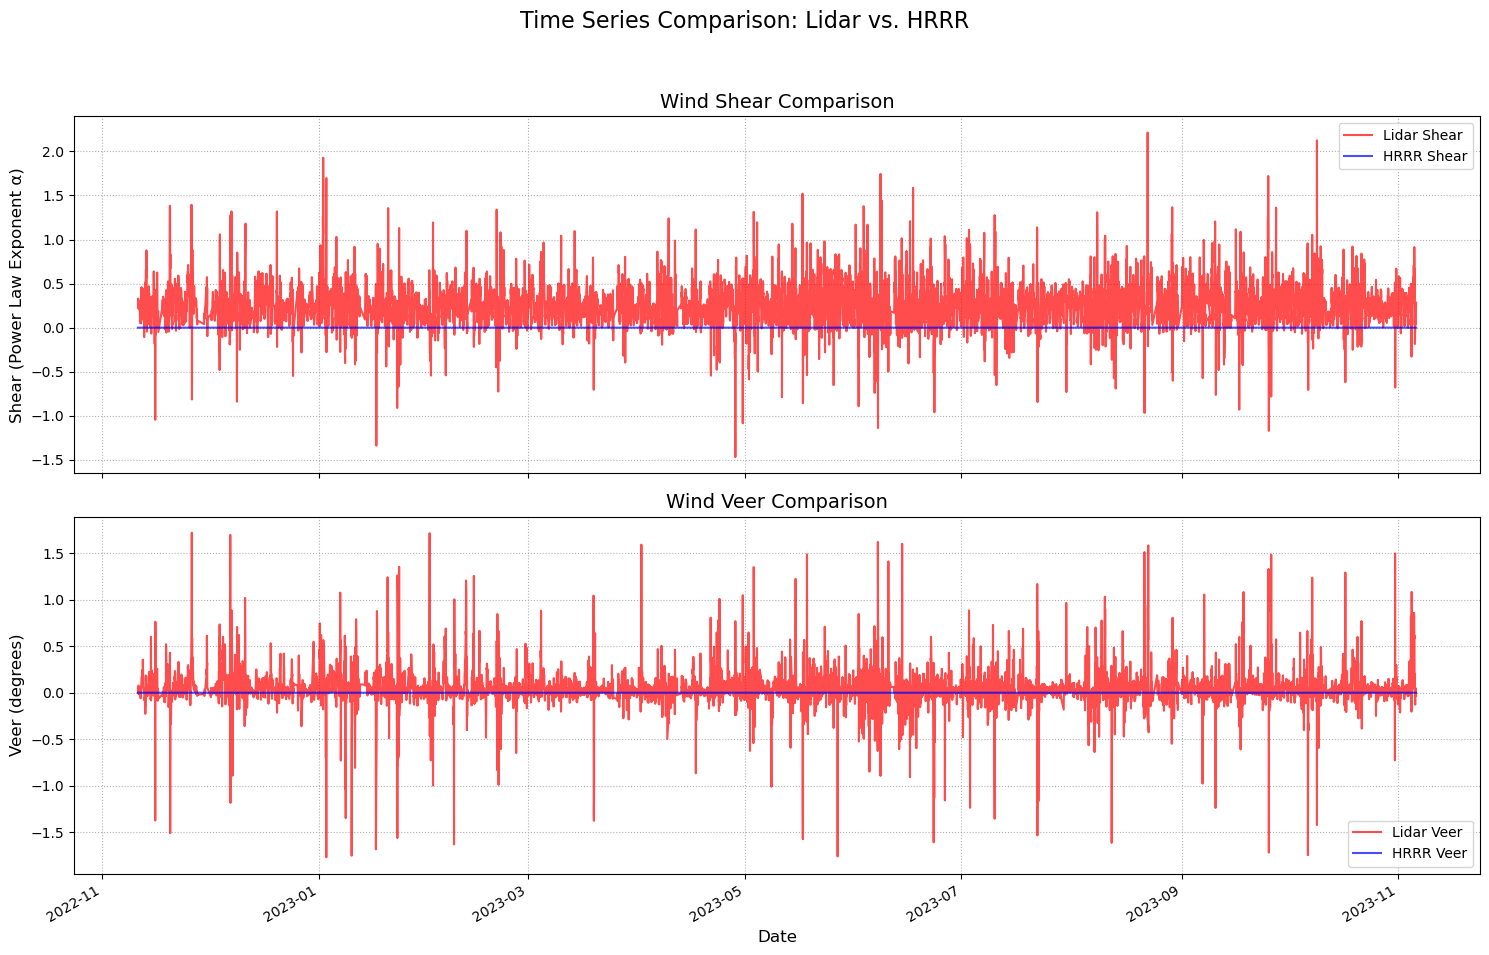

In [118]:
if not df_final_comparison.empty:
    print("\n--- Cell 6: Generating Comparison Time Series Plots ---")

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('Time Series Comparison: Lidar vs. HRRR', fontsize=16)

    # Plot Shear Comparison
    axes[0].plot(df_final_comparison['time'], df_final_comparison['shear_lidar'], label='Lidar Shear', color='red', alpha=0.7)
    axes[0].plot(df_final_comparison['time'], df_final_comparison['shear_hrrr'], label='HRRR Shear', color='blue', alpha=0.7)
    axes[0].set_ylabel('Shear (Power Law Exponent α)', fontsize=12)
    axes[0].set_title('Wind Shear Comparison', fontsize=14)
    axes[0].grid(True, linestyle=':')
    axes[0].legend()

    # Plot Veer Comparison
    axes[1].plot(df_final_comparison['time'], df_final_comparison['veer_lidar'], label='Lidar Veer', color='red', alpha=0.7)
    axes[1].plot(df_final_comparison['time'], df_final_comparison['veer_hrrr'], label='HRRR Veer', color='blue', alpha=0.7)
    axes[1].set_ylabel('Veer (degrees)', fontsize=12)
    axes[1].set_title('Wind Veer Comparison', fontsize=14)
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].grid(True, linestyle=':')
    axes[1].legend()

    # Formatting the x-axis for dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gcf().autofmt_xdate()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n--- Cell 6: Skipping plot generation (no merged data) ---")


--- Cell 7: Generating Scatter Plots ---


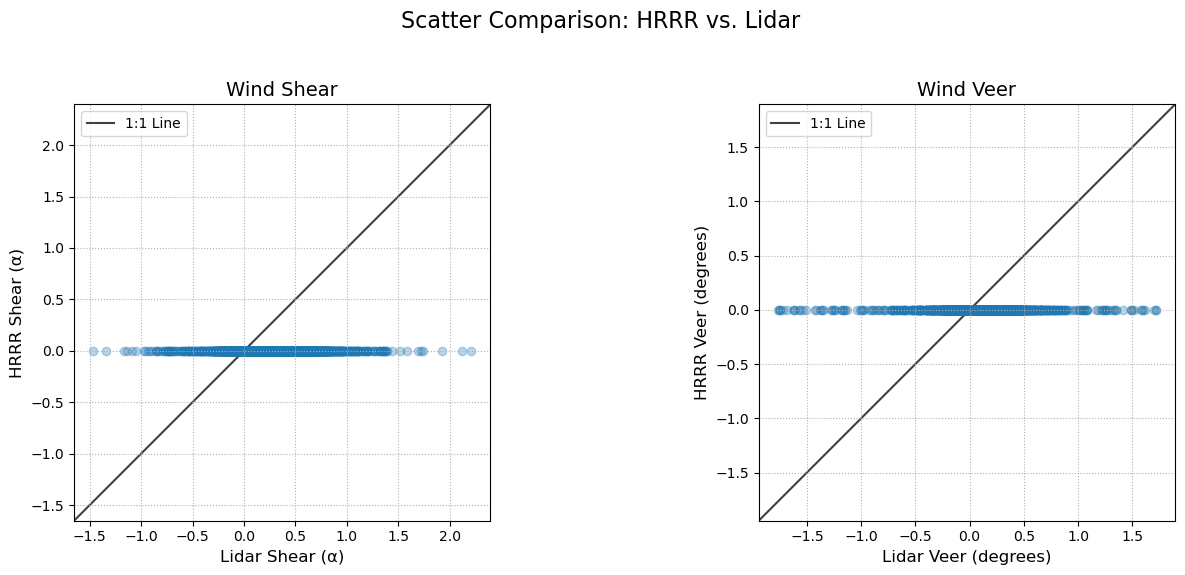

In [120]:
if not df_final_comparison.empty:
    print("\n--- Cell 7: Generating Scatter Plots ---")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle('Scatter Comparison: HRRR vs. Lidar', fontsize=16)

    # Shear Scatter Plot
    axes[0].scatter(df_final_comparison['shear_lidar'], df_final_comparison['shear_hrrr'], alpha=0.3)
    axes[0].set_xlabel('Lidar Shear (α)', fontsize=12)
    axes[0].set_ylabel('HRRR Shear (α)', fontsize=12)
    axes[0].set_title('Wind Shear', fontsize=14)
    # Add 1:1 line
    lims = [
        min(axes[0].get_xlim()[0], axes[0].get_ylim()[0]),
        max(axes[0].get_xlim()[1], axes[0].get_ylim()[1]),
    ]
    axes[0].plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='1:1 Line')
    axes[0].set_xlim(lims)
    axes[0].set_ylim(lims)
    axes[0].grid(True, linestyle=':')
    axes[0].legend()
    axes[0].set_aspect('equal', adjustable='box')


    # Veer Scatter Plot
    axes[1].scatter(df_final_comparison['veer_lidar'], df_final_comparison['veer_hrrr'], alpha=0.3)
    axes[1].set_xlabel('Lidar Veer (degrees)', fontsize=12)
    axes[1].set_ylabel('HRRR Veer (degrees)', fontsize=12)
    axes[1].set_title('Wind Veer', fontsize=14)
    # Add 1:1 line
    lims = [
        min(axes[1].get_xlim()[0], axes[1].get_ylim()[0]),
        max(axes[1].get_xlim()[1], axes[1].get_ylim()[1]),
    ]
    axes[1].plot(lims, lims, 'k-', alpha=0.75, zorder=0, label='1:1 Line')
    axes[1].set_xlim(lims)
    axes[1].set_ylim(lims)
    axes[1].grid(True, linestyle=':')
    axes[1].legend()
    axes[1].set_aspect('equal', adjustable='box')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\n--- Cell 7: Skipping plot generation (no merged data) ---")
